In [8]:
require 'nn'
require 'image'
require 'torch'
require 'xlua'
require 'optim'
--
trainData = torch.load('mnist.t7/train_32x32.t7', 'ascii')
testData  = torch.load('mnist.t7/test_32x32.t7', 'ascii')
trainData.size=function() return (#trainData.labels)[1] end
testData.size =function() return (#testData.labels)[1] end
print(trainData)
print(testData)

{


  data : ByteTensor - size: 60000x1x32x32
  size : function: 0x41665b80
  labels : ByteTensor - size: 60000
}
{
  data : ByteTensor - size: 10000x1x32x32
  size : function: 0x41665c08
  labels : ByteTensor - size: 10000
}


==> here is the weights:	


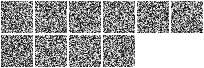

==> here is the model:	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.Reshape(1024)
  (2): nn.Linear(1024 -> 10)
  (3): nn.LogSoftMax
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 


        nn.Reshape(1024)
        {
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          size : LongStorage - size: 1
          nelement : 1024
          batchsize : LongStorage - size: 2
        }
      2 : 
        nn.Linear(1024 -> 10)
        {
          gradBias : DoubleTensor - size: 10
          weight : DoubleTensor - size: 10x1024
          gradWeight : DoubleTensor - size: 10x1024
          gradInput : DoubleTensor - empty
          bias : DoubleTensor - size: 10
          output : DoubleTensor - empty
        }
      3 : 
        nn.LogSoftMax
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }
    }
  output : DoubleTensor - empty
}
==> here is the criterion:	
nn.ClassNLLCriterion
{
  sizeAverage : true
  output : 0
  gradInput : DoubleTensor - empty
  output_tensor : DoubleTensor - size: 1
  target : LongTensor - size: 1
  total_weight_tensor : DoubleTensor - size: 1
}


In [9]:
nfeats=1
nrow=32
ncol=32
ninputs=nfeats*nrow*ncol
noutputs = 10
--
model=nn.Sequential()
model:add(nn.Reshape(ninputs))
model:add(nn.Linear(ninputs, noutputs))
model:add(nn.LogSoftMax())
--
print '==> here is the weights:'
itorch.image(model:get(2).weight:view(10,1,32,32))
--
print '==> here is the model:'
print(model)
--
criterion = nn.ClassNLLCriterion()
print '==> here is the criterion:'
print(criterion)

In [10]:
trsize=trainData:size()
tesize=testData:size()
print('trsize=' .. trsize)
print('tesize=' .. tesize)
--
classes = {'1','2','3','4','5','6','7','8','9','0'}
confusion = optim.ConfusionMatrix(classes)
trainLogger = optim.Logger(paths.concat('results', 'train.log'))
testLogger = optim.Logger(paths.concat('results', 'test.log'))
--
opt={}
opt.save='results'
opt.type='double'
opt.batchSize=64
if model then
    parameters,gradParameters = model:getParameters()
end
optimState = {
    learningRate = 0.01,
    weightDecay  = 0,
    momentum     = 0,
    learningRateDecay = 1e-7
}
optimMethod = optim.sgd
--
print '==> defining train procedure'
function train()
    epoch = epoch or 1
    local time = sys.clock()
    model:training()
    -- shuffle at each epoch
    shuffle = torch.randperm(trsize)
    -- do one epoch
    print('==> doing epoch on training data:')
    print("==> online epoch # " .. epoch .. ' [batchSize = ' .. opt.batchSize .. ']')
    for t = 1,trainData:size(),opt.batchSize do
        xlua.progress(t, trainData:size())
        -- create mini batch
        local inputs = {}
        local targets = {}
        for i = t,math.min(t+opt.batchSize-1,trainData:size()) do
            -- load new sample
            local input = trainData.data[shuffle[i]]
            local target = trainData.labels[shuffle[i]]
            if opt.type == 'double' then
                input = input:double()
            elseif opt.type == 'cuda' then
                input = input:cuda()
            end
            table.insert(inputs, input)
            table.insert(targets, target)
        end
        --
        local feval = function(x)
            -- get new parameters
            if x ~= parameters then
                parameters:copy(x)
            end
            -- reset gradients
            gradParameters:zero()
            -- f is the average of all criterions
            local f = 0
            -- evaluate function for complete mini batch
            for i = 1,#inputs do
                -- estimate f
                local output = model:forward(inputs[i])
                local err = criterion:forward(output, targets[i])
                f = f + err
                -- estimate df/dW
                local df_do = criterion:backward(output, targets[i])
                model:backward(inputs[i], df_do)
                -- update confusion
                confusion:add(torch.reshape(output,noutputs), targets[i])
            end
            
            -- normalize gradients and f(X)
            gradParameters:div(#inputs)
            f = f/#inputs
            -- return f and df/dX
            return f,gradParameters
        end
        -- optimize on current mini-batch
        optimMethod(feval, parameters, optimState)
    end
    -- time taken
    time = sys.clock() - time
    time = time / trainData:size()
    print("\n==> time to learn 1 sample = " .. (time*1000) .. 'ms')
    -- print confusion matrix
    print(confusion)
    -- update logger/plot
    trainLogger:add{['% mean class accuracy (train set)'] = confusion.totalValid * 100}
    if opt.plot then
        trainLogger:style{['% mean class accuracy (train set)'] = '-'}
        trainLogger:plot()
    end
    -- save/log current net
    local filename = paths.concat(opt.save, 'model.net')
    os.execute('mkdir -p ' .. sys.dirname(filename))
    print('==> saving model to '..filename)
    torch.save(filename, model)
    -- next epoch
    confusion:zero()
    epoch = epoch + 1
end
--

print '==> defining test procedure'
-- test function
function test()
   -- local vars
   local time = sys.clock()

   -- averaged param use?
   if average then
      cachedparams = parameters:clone()
      parameters:copy(average)
   end

   -- set model to evaluate mode (for modules that differ in training and testing, like Dropout)
   model:evaluate()

   -- test over test data
   print('==> testing on test set:')
   for t = 1,testData:size() do
      -- disp progress
      xlua.progress(t, testData:size())

      -- get new sample
      local input = testData.data[t]
      if opt.type == 'double' then input = input:double()
      elseif opt.type == 'cuda' then input = input:cuda() end
      local target = testData.labels[t]

      -- test sample
      local pred = model:forward(input)
      confusion:add(torch.reshape(pred,noutputs), target)
   end

   -- timing
   time = sys.clock() - time
   time = time / testData:size()
   print("\n==> time to test 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)

   -- update log/plot
   testLogger:add{['% mean class accuracy (test set)'] = confusion.totalValid * 100}
   if opt.plot then
      testLogger:style{['% mean class accuracy (test set)'] = '-'}
      testLogger:plot()
   end

   -- averaged param use?
   if average then
      -- restore parameters
      parameters:copy(cachedparams)
   end
   
   -- next iteration:
   confusion:zero()
end

trsize=60000	
tesize=10000	


==> defining train procedure	
==> defining test procedure	


==> doing epoch on training data:	
==> online epoch # 1 [batchSize = 64]	


Progress: 257 / 60000	


Progress: 513 / 60000	


Progress: 769 / 60000	


Progress: 1025 / 60000	


Progress: 1281 / 60000	


Progress: 1537 / 60000	


Progress: 1793 / 60000	


Progress: 2049 / 60000	


Progress: 2305 / 60000	


Progress: 2561 / 60000	


Progress: 2817 / 60000	


Progress: 3073 / 60000	


Progress: 3329 / 60000	


Progress: 3585 / 60000	


Progress: 3841 / 60000	


Progress: 4097 / 60000	


Progress: 4353 / 60000	


Progress: 4609 / 60000	


Progress: 4865 / 60000	


Progress: 5121 / 60000	


Progress: 5377 / 60000	


Progress: 5633 / 60000	


Progress: 5889 / 60000	


Progress: 6145 / 60000	


Progress: 6401 / 60000	


Progress: 6657 / 60000	


Progress: 6913 / 60000	


Progress: 7169 / 60000	


Progress: 7425 / 60000	


Progress: 7681 / 60000	


Progress: 7937 / 60000	


Progress: 8193 / 60000	


Progress: 8449 / 60000	


Progress: 8705 / 60000	


Progress: 8961 / 60000	


Progress: 9217 / 60000	


Progress: 9473 / 60000	


Progress: 9729 / 60000	


Progress: 9985 / 60000	


Progress: 10241 / 60000	


Progress: 10497 / 60000	


Progress: 10753 / 60000	


Progress: 11009 / 60000	


Progress: 11265 / 60000	


Progress: 11521 / 60000	


Progress: 11777 / 60000	


Progress: 12033 / 60000	


Progress: 12289 / 60000	


Progress: 12545 / 60000	


Progress: 12801 / 60000	


Progress: 13057 / 60000	


Progress: 13313 / 60000	


Progress: 13569 / 60000	


Progress: 13825 / 60000	


Progress: 14081 / 60000	


Progress: 14337 / 60000	


Progress: 14593 / 60000	


Progress: 14849 / 60000	


Progress: 15105 / 60000	


Progress: 15361 / 60000	


Progress: 15617 / 60000	


Progress: 15873 / 60000	


Progress: 16129 / 60000	


Progress: 16385 / 60000	


Progress: 16641 / 60000	


Progress: 16897 / 60000	


Progress: 17153 / 60000	


Progress: 17409 / 60000	


Progress: 17665 / 60000	


Progress: 17921 / 60000	


Progress: 18177 / 60000	


Progress: 18433 / 60000	


Progress: 18689 / 60000	


Progress: 18945 / 60000	


Progress: 19201 / 60000	


Progress: 19457 / 60000	


Progress: 19713 / 60000	


Progress: 19969 / 60000	


Progress: 20225 / 60000	


Progress: 20481 / 60000	


Progress: 20737 / 60000	


Progress: 20993 / 60000	


Progress: 21249 / 60000	


Progress: 21505 / 60000	


Progress: 21761 / 60000	


Progress: 22017 / 60000	


Progress: 22273 / 60000	


Progress: 22529 / 60000	


Progress: 22785 / 60000	


Progress: 23041 / 60000	


Progress: 23297 / 60000	


Progress: 23553 / 60000	


Progress: 23809 / 60000	


Progress: 24065 / 60000	


Progress: 24321 / 60000	


Progress: 24577 / 60000	


Progress: 24833 / 60000	


Progress: 25089 / 60000	


Progress: 25345 / 60000	


Progress: 25601 / 60000	


Progress: 25857 / 60000	


Progress: 26113 / 60000	


Progress: 26369 / 60000	


Progress: 26625 / 60000	


Progress: 26881 / 60000	


Progress: 27137 / 60000	


Progress: 27393 / 60000	


Progress: 27649 / 60000	


Progress: 27905 / 60000	


Progress: 28161 / 60000	


Progress: 28417 / 60000	


Progress: 28673 / 60000	


Progress: 28929 / 60000	


Progress: 29185 / 60000	


Progress: 29441 / 60000	


Progress: 29697 / 60000	


Progress: 29953 / 60000	


Progress: 30209 / 60000	


Progress: 30465 / 60000	


Progress: 30721 / 60000	


Progress: 30977 / 60000	


Progress: 31233 / 60000	


Progress: 31489 / 60000	


Progress: 31745 / 60000	


Progress: 32001 / 60000	


Progress: 32257 / 60000	


Progress: 32513 / 60000	


Progress: 32769 / 60000	


Progress: 33025 / 60000	


Progress: 33281 / 60000	


Progress: 33537 / 60000	


Progress: 33793 / 60000	


Progress: 34049 / 60000	


Progress: 34305 / 60000	


Progress: 34561 / 60000	


Progress: 34817 / 60000	


Progress: 35073 / 60000	


Progress: 35329 / 60000	


Progress: 35585 / 60000	


Progress: 35841 / 60000	


Progress: 36097 / 60000	


Progress: 36353 / 60000	


Progress: 36609 / 60000	


Progress: 36865 / 60000	


Progress: 37121 / 60000	


Progress: 37377 / 60000	


Progress: 37633 / 60000	


Progress: 37889 / 60000	


Progress: 38145 / 60000	


Progress: 38401 / 60000	


Progress: 38657 / 60000	


Progress: 38913 / 60000	


Progress: 39169 / 60000	


Progress: 39425 / 60000	


Progress: 39681 / 60000	


Progress: 39937 / 60000	


Progress: 40193 / 60000	


Progress: 40449 / 60000	


Progress: 40705 / 60000	


Progress: 40961 / 60000	


Progress: 41217 / 60000	


Progress: 41473 / 60000	


Progress: 41729 / 60000	


Progress: 41985 / 60000	


Progress: 42241 / 60000	


Progress: 42497 / 60000	


Progress: 42753 / 60000	


Progress: 43009 / 60000	


Progress: 43265 / 60000	


Progress: 43521 / 60000	


Progress: 43777 / 60000	


Progress: 44033 / 60000	


Progress: 44289 / 60000	


Progress: 44545 / 60000	


Progress: 44801 / 60000	


Progress: 45057 / 60000	


Progress: 45313 / 60000	


Progress: 45569 / 60000	


Progress: 45825 / 60000	


Progress: 46081 / 60000	


Progress: 46337 / 60000	


Progress: 46593 / 60000	


Progress: 46849 / 60000	


Progress: 47105 / 60000	


Progress: 47361 / 60000	


Progress: 47617 / 60000	


Progress: 47873 / 60000	


Progress: 48129 / 60000	


Progress: 48385 / 60000	


Progress: 48641 / 60000	


Progress: 48897 / 60000	


Progress: 49153 / 60000	


Progress: 49409 / 60000	


Progress: 49665 / 60000	


Progress: 49921 / 60000	


Progress: 50177 / 60000	


Progress: 50433 / 60000	


Progress: 50689 / 60000	


Progress: 50945 / 60000	


Progress: 51201 / 60000	


Progress: 51457 / 60000	


Progress: 51713 / 60000	


Progress: 51969 / 60000	


Progress: 52225 / 60000	


Progress: 52481 / 60000	


Progress: 52737 / 60000	


Progress: 52993 / 60000	


Progress: 53249 / 60000	


Progress: 53505 / 60000	


Progress: 53761 / 60000	


Progress: 54017 / 60000	


Progress: 54273 / 60000	


Progress: 54529 / 60000	


Progress: 54785 / 60000	


Progress: 55041 / 60000	


Progress: 55297 / 60000	


Progress: 55553 / 60000	


Progress: 55809 / 60000	

Progress: 56065 / 60000	


Progress: 56321 / 60000	


Progress: 56577 / 60000	


Progress: 56833 / 60000	


Progress: 57089 / 60000	


Progress: 57345 / 60000	


Progress: 57601 / 60000	


Progress: 57857 / 60000	


Progress: 58113 / 60000	


Progress: 58369 / 60000	


Progress: 58625 / 60000	


Progress: 58881 / 60000	


Progress: 59137 / 60000	


Progress: 59393 / 60000	


Progress: 59649 / 60000	


Progress: 59905 / 60000	



==> time to learn 1 sample = 9.2680948177973ms	
ConfusionMatrix:
[[    5488       0      54      38      19     144      64      18      85      13]   92.656% 	[class: 1]
 [       1    6236      84      62      16      37       9      29     249      19]   92.495% 	[class: 2]
 [      60      82    4944     187      93      40     138     102     261      51]   82.981% 	[class: 3]
 [      44      41     196    5020      14     350      35      70     270      91]   81.879% 	[class: 4]
 [      25      27      53      31    4981      25      87      38     122     453]   85.262% 	[class: 5]
 [     132      42      73     337     100    3977     124      37     498     101]   73.363% 	[class: 6]
 [      66      27     138      13      89     120    5356       7      87      15]   90.504% 	[class: 7]
 [      37      45     112      69      80      15       4    5390      50     463]   86.034% 	[class: 8]
 [      67     193     215     300      52     376      76      46    4319     207]   

 averageValid : 0.83595957756042
  classes : 
    {
      1 : 1
      2 : 2
      3 : 3
      4 : 4
      5 : 5
      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 0
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.83816666666667
}


==> saving model to /home/ubuntu/gitlab.altoros/776_DL_Libs_Benchmark.git/src/Step02/SubStep-02-Torch/results/model.net	


==> testing on test set:	


Progress: 7204 / 10000	



==> time to test 1 sample = 0.12617728710175ms	


ConfusionMatrix:
[[     968       0       0       0       1       1       1       1       8       0]   98.776% 	[class: 1]
 [       0    1036       4       1       0      10       3       3      78       0]   91.278% 	[class: 2]
 [      18      11     891       0      19       1       8       8      75       1]   86.337% 	[class: 3]
 [      13       3      79     610      10     114       3      22     156       0]   60.396% 	[class: 4]
 [       5       0       3       0     959       0       6       1       8       0]   97.658% 	[class: 5]
 [      18       2       2       5      22     751      10       5      77       0]   84.193% 	[class: 6]
 [      27       2       8       0      29      24     849       2      17       0]   88.622% 	[class: 7]
 [       4       5      23       1      33       1       0     930      26       5]   90.467% 	[class: 8]
 [       8       3       3       1      42      20       4       4     889       0]   91.273% 	[class: 9]
 [      19       4       2   

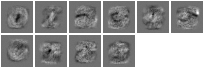

In [11]:
numEpoch=1
for i=1,numEpoch do
    train()
    test()
end
print '==> trained model weights:'
itorch.image(model:get(2).weight:view(10,1,32,32))